In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 230
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  ZK75TX1R_13_29_31
NN-MODEL FILENAME:  ./models/ZK75TX1R_13_29_31_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 20
NO_OF_EPISODES = 200
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  20
Number of EPISODES per NODE 200


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000

In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  4.5
P_VEL_ABS_MIN = -4.5

LENGTH_ABS_MAX = 0.8
LENGTH_ABS_MIN = 0.2

In [14]:
# SET GRANULARITY
LO_GRAIN = 15
HI_GRAIN = 30
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  30
LO_GRAIN =  15


In [15]:
def mp_node_run(node_id, boundary):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.5 + (1.5 - 0.5) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
        
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################

    
#     my_dqn = D3QN()
#     my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
#     my_dqn.eval_net.eval()
    my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    my_Q_TABLE = np.load(my_QFILE)
#     my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , LO_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR

    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.05,0.05)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
#                                                                          my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.1, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.1, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

 # SET STATE VALUE BORDERS
###############################################
[C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
 C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
###############################################

# CREATE STATE COMBINATIONS
###############################################

init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
###############################################

# GET Q-VALUES 
start = timeit.default_timer()
% memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
for node_id in range(NO_OF_NODES):
    node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
    np.save(node_QFILE, init_q_table)
#############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES

peak memory: 5613.06 MiB, increment: 5006.84 MiB
Quantization TIME:  0.05 minutes




ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 111
REAL TIME TO GENERATE 59691 EXPERIENCES:0:00:01.712575


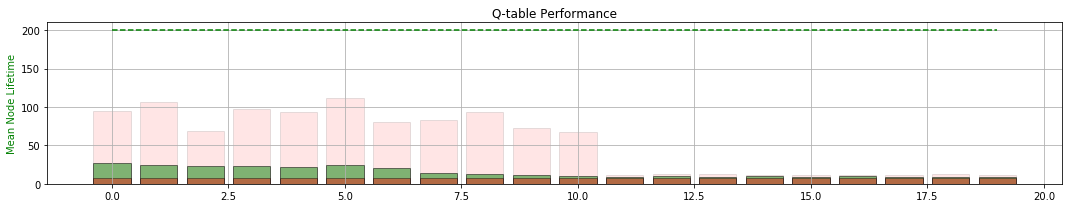

GOOD MEMORY COUNTER:  55691
BAD MEMORY COUNTER:  4000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  57.95
Validating... MEAN TIME:  120.695
Validating... MEAN TIME:  191.47
Validating... MEAN TIME:  199.02
Validating... MEAN TIME:  185.63
TRAINING TIME:0:00:39.406363


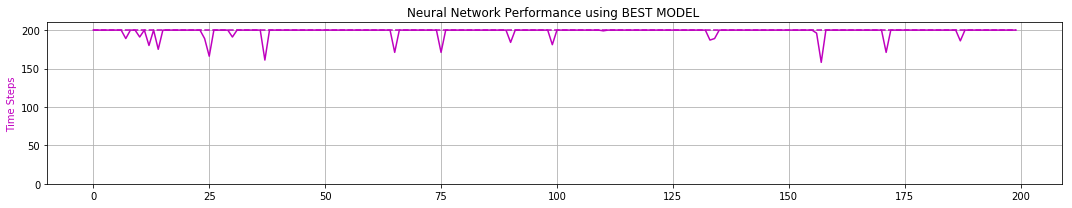

0 -max- [ 0.338  1.996  0.209  1.059  0.425]
0 -min- [-0.051 -0.241 -0.209 -2.945  0.200]

peak memory: 6309.68 MiB, increment: 5140.31 MiB
1 -max- [ 0.286  1.918  0.209  0.922  0.450]
1 -min- [-0.050 -0.218 -0.209 -2.949  0.200]

peak memory: 6221.28 MiB, increment: 5006.50 MiB
2 -max- [ 0.307  2.174  0.209  0.812  0.475]
2 -min- [-0.050 -0.202 -0.209 -2.969  0.200]

peak memory: 6247.06 MiB, increment: 5032.04 MiB
3 -max- [ 0.848  2.514  0.208  0.787  0.499]
3 -min- [-0.050 -0.207 -0.209 -2.979  0.200]

peak memory: 6327.24 MiB, increment: 5112.41 MiB
4 -max- [ 0.803  2.287  0.209  1.098  0.524]
4 -min- [-0.050 -0.214 -0.209 -2.930  0.226]

peak memory: 6394.61 MiB, increment: 5180.21 MiB
5 -max- [ 0.463  2.120  0.209  0.921  0.550]
5 -min- [-0.050 -0.402 -0.209 -2.964  0.250]

peak memory: 6312.77 MiB, increment: 5098.31 MiB
6 -max- [ 0.577  1.987  0.206  0.877  0.574]
6 -min- [-0.050 -0.219 -0.209 -2.946  0.276]

peak memory: 6220.50 MiB, increment: 5005.97 MiB
7 -max- [ 0.472  1.9

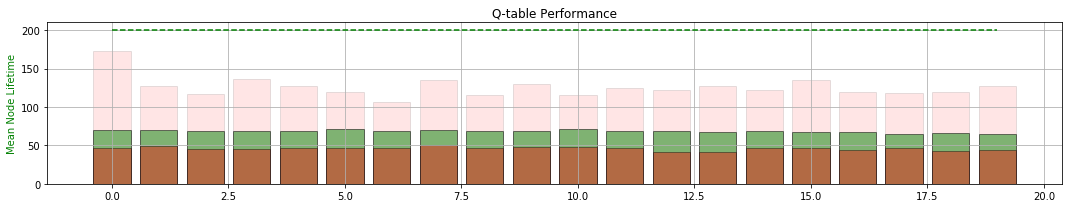

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  108.355
Validating... MEAN TIME:  31.575
Validating... MEAN TIME:  61.825
Validating... MEAN TIME:  29.94
Validating... MEAN TIME:  78.94
TRAINING TIME:0:00:22.085143


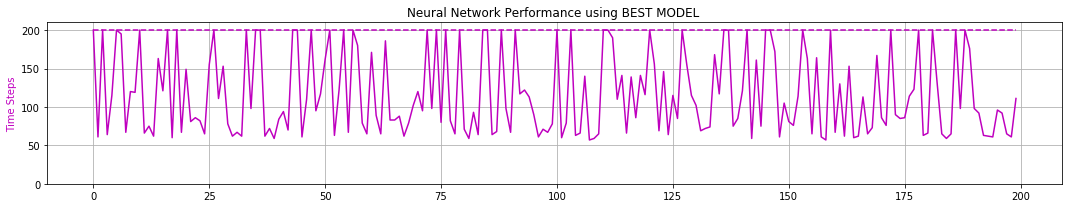

0 -max- [ 0.334  0.624  0.056  0.626  0.425]
0 -min- [-0.535 -1.589 -0.209 -0.799  0.200]

peak memory: 6460.70 MiB, increment: 5153.19 MiB
1 -max- [ 0.227  0.601  0.049  0.626  0.450]
1 -min- [-0.561 -1.478 -0.209 -0.829  0.200]

peak memory: 6472.54 MiB, increment: 5164.97 MiB
2 -max- [ 0.186  0.583  0.049  0.622  0.474]
2 -min- [-0.793 -1.633 -0.209 -0.831  0.200]

peak memory: 6312.90 MiB, increment: 5005.27 MiB
3 -max- [ 0.276  0.625  0.049  0.572  0.499]
3 -min- [-0.707 -1.490 -0.209 -0.919  0.200]

peak memory: 6312.99 MiB, increment: 5005.58 MiB
4 -max- [ 0.195  0.544  0.050  0.559  0.525]
4 -min- [-0.621 -1.457 -0.209 -0.814  0.226]

peak memory: 6441.14 MiB, increment: 5133.92 MiB
5 -max- [ 0.203  0.594  0.050  0.622  0.549]
5 -min- [-0.638 -1.492 -0.209 -1.125  0.250]

peak memory: 6312.71 MiB, increment: 5005.42 MiB
6 -max- [ 0.199  0.554  0.051  0.639  0.575]
6 -min- [-0.600 -1.490 -0.209 -1.094  0.275]

peak memory: 6405.45 MiB, increment: 5098.09 MiB
7 -max- [ 0.174  0.7

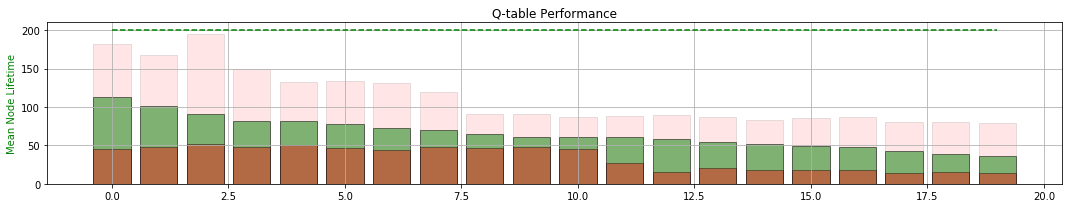

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  173.685
Validating... MEAN TIME:  152.19
Validating... MEAN TIME:  118.405
Validating... MEAN TIME:  193.41
Validating... MEAN TIME:  190.91
TRAINING TIME:0:00:42.350457


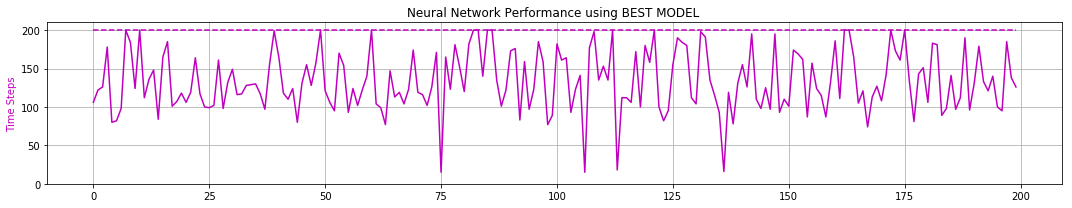

0 -max- [ 0.172  1.759  0.209  1.970  0.425]
0 -min- [-1.153 -2.130 -0.209 -2.569  0.200]

peak memory: 6452.11 MiB, increment: 5084.26 MiB
1 -max- [ 0.166  1.600  0.209  2.246  0.450]
1 -min- [-1.140 -2.514 -0.209 -2.345  0.200]

peak memory: 6447.80 MiB, increment: 5079.93 MiB
2 -max- [ 0.165  1.608  0.209  2.306  0.475]
2 -min- [-1.078 -2.502 -0.209 -2.588  0.200]

peak memory: 6376.70 MiB, increment: 5009.02 MiB
3 -max- [ 0.142  1.552  0.209  2.567  0.499]
3 -min- [-1.177 -2.853 -0.209 -2.579  0.200]

peak memory: 6373.18 MiB, increment: 5005.43 MiB
4 -max- [ 0.157  1.424  0.209  2.171  0.525]
4 -min- [-1.215 -2.481 -0.209 -2.438  0.226]

peak memory: 6519.04 MiB, increment: 5151.22 MiB
5 -max- [ 0.150  1.410  0.209  2.249  0.550]
5 -min- [-1.117 -2.475 -0.209 -2.322  0.252]

peak memory: 6445.21 MiB, increment: 5077.83 MiB
6 -max- [ 0.141  1.420  0.209  2.200  0.575]
6 -min- [-1.133 -2.488 -0.209 -2.341  0.276]

peak memory: 6372.89 MiB, increment: 5005.45 MiB
7 -max- [ 0.121  1.4

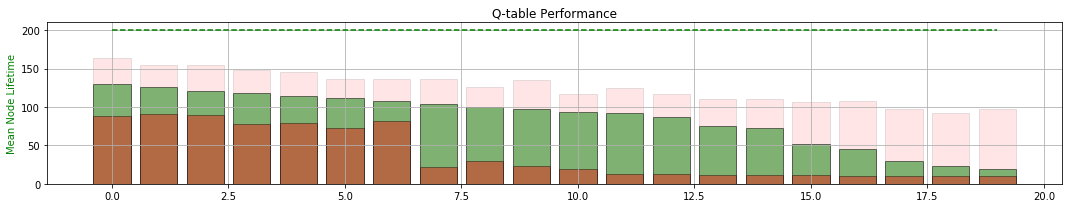

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  118.53
Validating... MEAN TIME:  105.01
Validating... MEAN TIME:  109.675
Validating... MEAN TIME:  135.705
Validating... MEAN TIME:  157.38
TRAINING TIME:0:00:34.406214


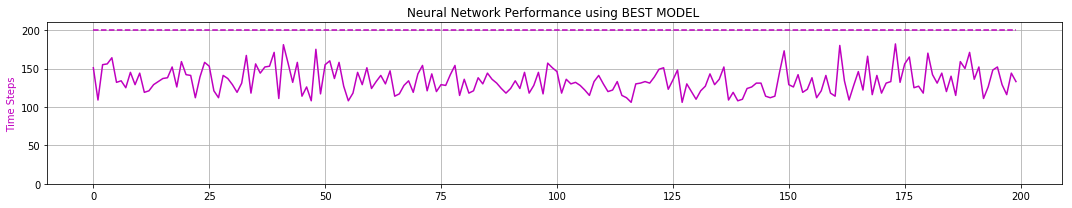

0 -max- [ 0.137  0.814  0.055  1.572  0.424]
0 -min- [-2.397 -3.175 -0.209 -2.003  0.200]

peak memory: 6535.50 MiB, increment: 5098.14 MiB
1 -max- [ 0.145  0.732  0.053  1.569  0.448]
1 -min- [-2.400 -3.207 -0.209 -2.437  0.200]

peak memory: 6431.80 MiB, increment: 4994.40 MiB
2 -max- [ 0.147  0.633  0.052  1.503  0.475]
2 -min- [-2.400 -3.175 -0.209 -2.338  0.200]

peak memory: 6442.82 MiB, increment: 5005.35 MiB
3 -max- [ 0.153  0.751  0.060  1.548  0.500]
3 -min- [-2.399 -3.210 -0.209 -2.213  0.201]

peak memory: 6441.23 MiB, increment: 5003.69 MiB
4 -max- [ 0.164  0.823  0.106  1.565  0.523]
4 -min- [-2.400 -3.197 -0.209 -2.497  0.226]

peak memory: 6460.27 MiB, increment: 5022.92 MiB
5 -max- [ 0.169  0.821  0.054  1.512  0.550]
5 -min- [-2.400 -3.171 -0.209 -2.423  0.251]

peak memory: 6431.31 MiB, increment: 4993.63 MiB
6 -max- [ 0.158  0.990  0.052  1.506  0.575]
6 -min- [-2.399 -3.175 -0.209 -2.629  0.276]

peak memory: 6497.01 MiB, increment: 5059.25 MiB
7 -max- [ 0.162  0.9

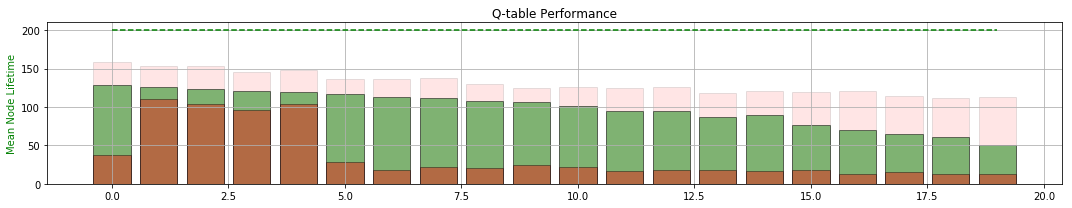

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  110.48
Validating... MEAN TIME:  111.1
Validating... MEAN TIME:  136.315
Validating... MEAN TIME:  105.265
Validating... MEAN TIME:  142.665
TRAINING TIME:0:00:32.788541


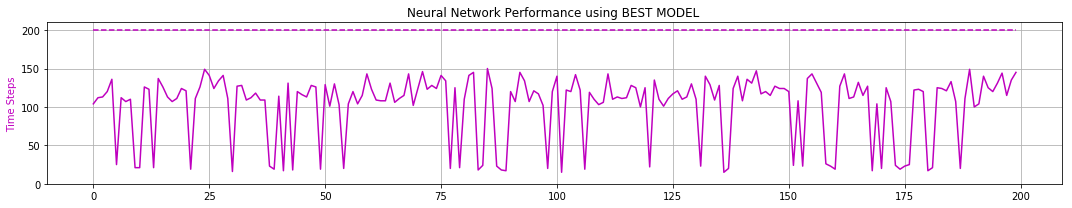

0 -max- [ 0.142  0.618  0.072  1.323  0.425]
0 -min- [-2.400 -2.797 -0.209 -0.961  0.200]

peak memory: 6459.80 MiB, increment: 5005.73 MiB
1 -max- [ 0.148  0.610  0.077  1.550  0.449]
1 -min- [-2.400 -2.812 -0.209 -1.170  0.200]

peak memory: 6459.69 MiB, increment: 5005.33 MiB
2 -max- [ 0.141  0.608  0.059  1.306  0.475]
2 -min- [-2.399 -2.806 -0.209 -1.009  0.200]

peak memory: 6459.92 MiB, increment: 5005.48 MiB
3 -max- [ 0.145  0.809  0.051  1.310  0.499]
3 -min- [-2.400 -2.803 -0.208 -1.198  0.201]

peak memory: 6579.55 MiB, increment: 5125.30 MiB
4 -max- [ 0.160  0.625  0.050  1.304  0.524]
4 -min- [-2.400 -2.980 -0.209 -1.292  0.225]

peak memory: 6459.58 MiB, increment: 5005.52 MiB
5 -max- [ 0.162  0.633  0.050  1.299  0.549]
5 -min- [-2.399 -3.177 -0.209 -1.043  0.250]

peak memory: 6459.63 MiB, increment: 5005.50 MiB
6 -max- [ 0.148  0.792  0.059  1.285  0.574]
6 -min- [-2.399 -2.973 -0.209 -1.216  0.276]

peak memory: 6607.86 MiB, increment: 5153.92 MiB
7 -max- [ 0.140  0.6

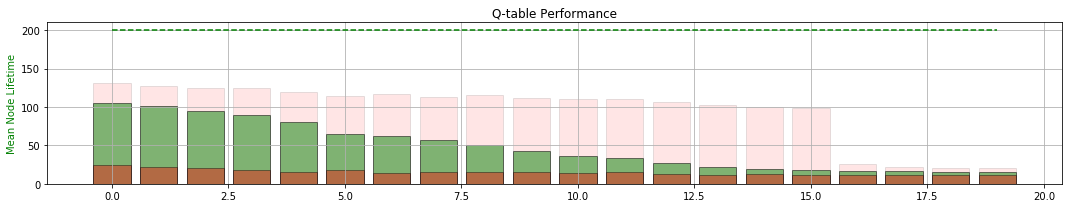

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  24000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  118.905
Validating... MEAN TIME:  16.475
Validating... MEAN TIME:  122.94
Validating... MEAN TIME:  45.11
Validating... MEAN TIME:  16.315
TRAINING TIME:0:00:22.653220


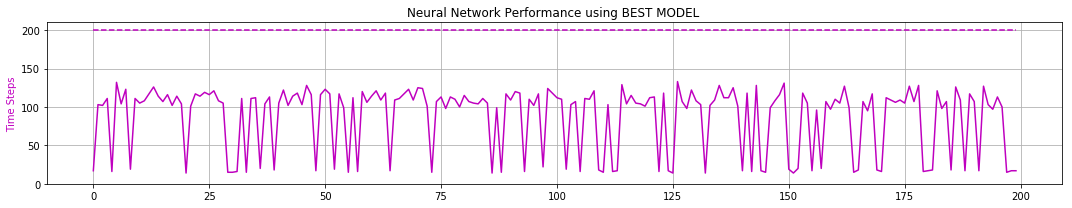

0 -max- [ 0.178  0.634  0.051  1.510  0.424]
0 -min- [-2.400 -3.172 -0.209 -1.085  0.200]

peak memory: 6535.50 MiB, increment: 5153.19 MiB
1 -max- [ 0.185  0.790  0.049  1.476  0.449]
1 -min- [-2.400 -3.180 -0.209 -1.208  0.200]

peak memory: 6387.65 MiB, increment: 5005.32 MiB
2 -max- [ 0.187  0.812  0.049  1.502  0.474]
2 -min- [-2.400 -3.181 -0.209 -1.124  0.200]

peak memory: 6387.81 MiB, increment: 5005.41 MiB
3 -max- [ 0.180  0.822  0.049  1.454  0.500]
3 -min- [-2.400 -3.182 -0.209 -1.182  0.201]

peak memory: 6377.64 MiB, increment: 4995.17 MiB
4 -max- [ 0.194  0.811  0.050  1.508  0.524]
4 -min- [-2.400 -3.181 -0.209 -1.189  0.225]

peak memory: 6377.71 MiB, increment: 4995.17 MiB
5 -max- [ 0.186  0.829  0.050  1.248  0.550]
5 -min- [-2.399 -3.108 -0.209 -1.247  0.250]

peak memory: 6572.25 MiB, increment: 5189.64 MiB
6 -max- [ 0.172  0.818  0.051  1.468  0.575]
6 -min- [-2.398 -2.984 -0.209 -1.423  0.275]

peak memory: 6554.69 MiB, increment: 5172.01 MiB
7 -max- [ 0.177  0.8

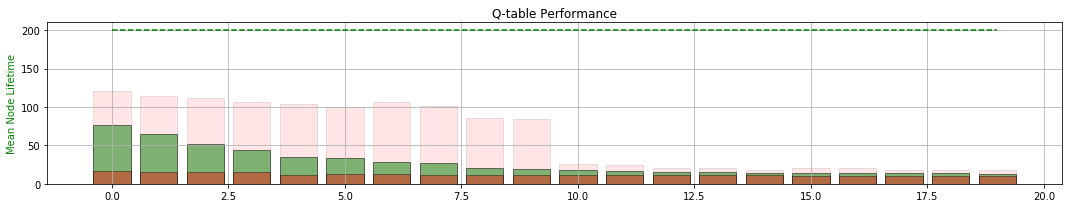

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  28000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  32.105
Validating... MEAN TIME:  17.91
Validating... MEAN TIME:  34.4
Validating... MEAN TIME:  14.12
Validating... MEAN TIME:  139.12
TRAINING TIME:0:00:19.399663


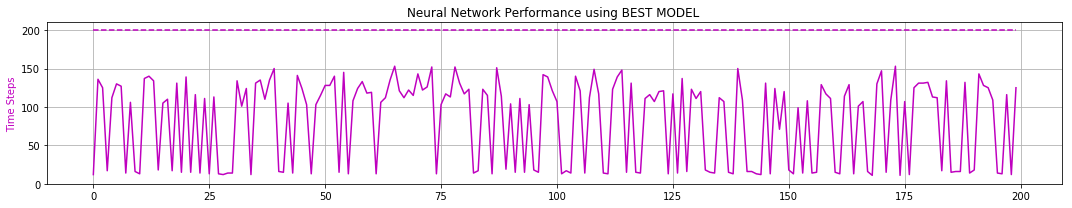

0 -max- [ 0.181  0.966  0.051  1.148  0.425]
0 -min- [-2.400 -3.164 -0.209 -1.374  0.200]

peak memory: 6343.20 MiB, increment: 4960.56 MiB
1 -max- [ 0.184  0.936  0.056  0.972  0.449]
1 -min- [-2.400 -3.334 -0.209 -1.337  0.200]

peak memory: 6386.66 MiB, increment: 5004.00 MiB
2 -max- [ 0.182  1.015  0.049  0.965  0.472]
2 -min- [-2.399 -3.324 -0.209 -1.480  0.200]

peak memory: 6350.91 MiB, increment: 4968.18 MiB
3 -max- [ 0.182  1.000  0.049  1.176  0.498]
3 -min- [-2.397 -3.335 -0.209 -1.374  0.200]

peak memory: 6343.20 MiB, increment: 4960.38 MiB
4 -max- [ 0.190  1.018  0.050  0.973  0.525]
4 -min- [-2.364 -3.166 -0.209 -1.372  0.225]

peak memory: 6354.23 MiB, increment: 4971.34 MiB
5 -max- [ 0.197  1.015  0.050  0.941  0.549]
5 -min- [-2.337 -2.927 -0.209 -1.372  0.250]

peak memory: 6343.20 MiB, increment: 4960.23 MiB
6 -max- [ 0.196  0.991  0.051  0.928  0.574]
6 -min- [-2.375 -3.144 -0.209 -1.390  0.275]

peak memory: 6418.68 MiB, increment: 5035.64 MiB
7 -max- [ 0.186  0.9

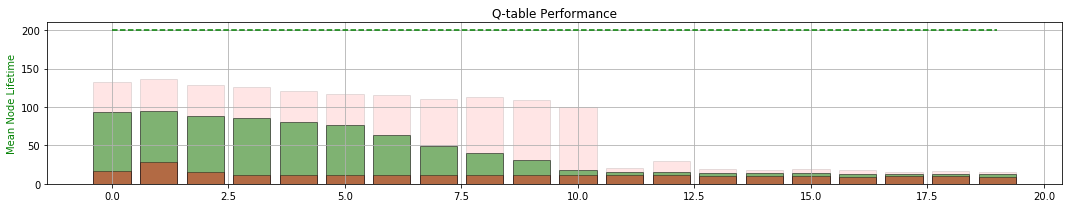

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  32000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  107.39
Validating... MEAN TIME:  13.39
Validating... MEAN TIME:  12.715
Validating... MEAN TIME:  105.445
Validating... MEAN TIME:  12.95
TRAINING TIME:0:00:19.955894


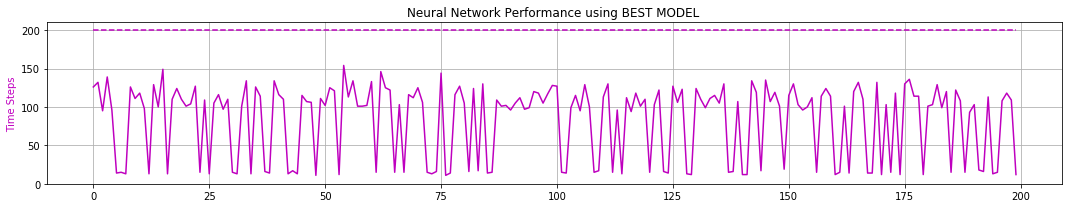

0 -max- [ 0.152  0.827  0.208  3.543  0.425]
0 -min- [-2.396 -4.162 -0.209 -1.631  0.200]

peak memory: 6429.23 MiB, increment: 5051.69 MiB
1 -max- [ 0.161  0.819  0.208  3.469  0.449]
1 -min- [-2.400 -3.590 -0.209 -1.906  0.200]

peak memory: 6338.86 MiB, increment: 4961.30 MiB
2 -max- [ 0.174  0.795  0.203  3.517  0.474]
2 -min- [-2.397 -3.565 -0.209 -1.623  0.200]

peak memory: 6338.86 MiB, increment: 4961.23 MiB
3 -max- [ 0.180  0.823  0.197  3.465  0.499]
3 -min- [-2.398 -3.769 -0.209 -1.690  0.201]

peak memory: 6488.51 MiB, increment: 5110.80 MiB
4 -max- [ 0.188  0.823  0.199  3.384  0.523]
4 -min- [-2.398 -3.579 -0.209 -1.532  0.225]

peak memory: 6338.86 MiB, increment: 4961.08 MiB
5 -max- [ 0.197  1.004  0.185  3.344  0.549]
5 -min- [-2.400 -3.714 -0.209 -1.974  0.250]

peak memory: 6460.89 MiB, increment: 5083.04 MiB
6 -max- [ 0.194  0.971  0.137  2.042  0.573]
6 -min- [-2.399 -3.598 -0.209 -1.738  0.275]

peak memory: 6435.71 MiB, increment: 5058.04 MiB
7 -max- [ 0.194  0.9

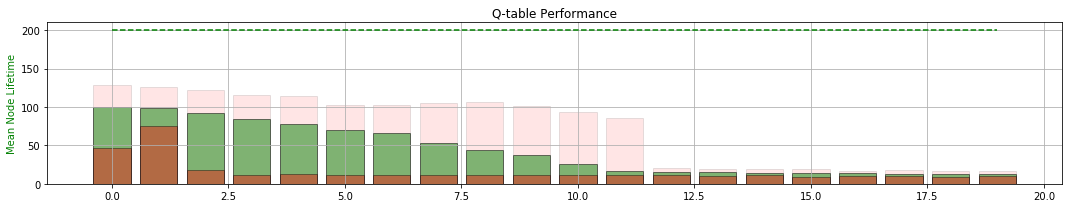

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  36000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  81.43
Validating... MEAN TIME:  153.73
Validating... MEAN TIME:  15.785
Validating... MEAN TIME:  153.97
Validating... MEAN TIME:  144.1
TRAINING TIME:0:00:30.166350


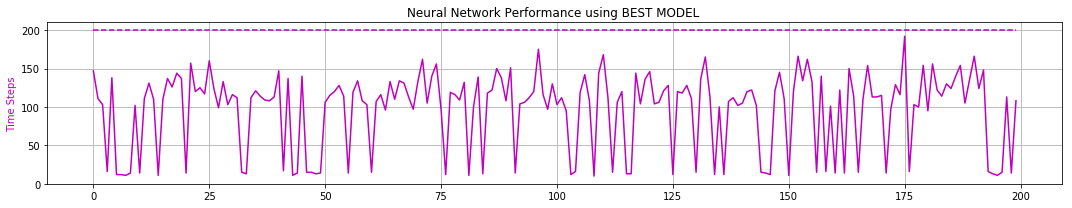

0 -max- [ 0.142  0.635  0.051  1.203  0.424]
0 -min- [-2.396 -2.924 -0.209 -1.142  0.200]

peak memory: 6474.86 MiB, increment: 5096.60 MiB
1 -max- [ 0.198  0.813  0.049  1.235  0.449]
1 -min- [-2.387 -2.976 -0.209 -1.254  0.200]

peak memory: 6486.85 MiB, increment: 5108.84 MiB
2 -max- [ 0.158  0.830  0.049  1.231  0.474]
2 -min- [-2.382 -2.974 -0.209 -1.243  0.200]

peak memory: 6531.32 MiB, increment: 5153.24 MiB
3 -max- [ 0.166  0.803  0.049  1.287  0.499]
3 -min- [-2.306 -2.791 -0.209 -1.420  0.201]

peak memory: 6376.08 MiB, increment: 4997.93 MiB
4 -max- [ 0.190  0.809  0.050  1.132  0.525]
4 -min- [-2.373 -2.790 -0.209 -1.267  0.225]

peak memory: 6435.89 MiB, increment: 5057.66 MiB
5 -max- [ 0.194  0.828  0.055  1.231  0.550]
5 -min- [-2.168 -2.784 -0.209 -1.442  0.250]

peak memory: 6383.70 MiB, increment: 5005.41 MiB
6 -max- [ 0.185  0.967  0.051  1.005  0.574]
6 -min- [-2.031 -2.592 -0.209 -1.366  0.275]

peak memory: 6542.69 MiB, increment: 5164.33 MiB
7 -max- [ 0.180  0.9

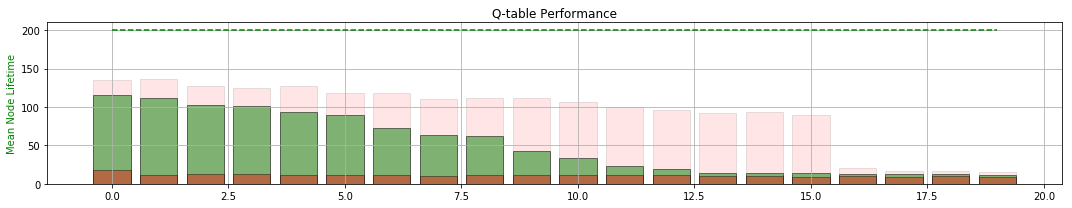

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  40000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  117.465
Validating... MEAN TIME:  102.86
Validating... MEAN TIME:  100.135
Validating... MEAN TIME:  14.165
Validating... MEAN TIME:  142.585
TRAINING TIME:0:00:28.434468


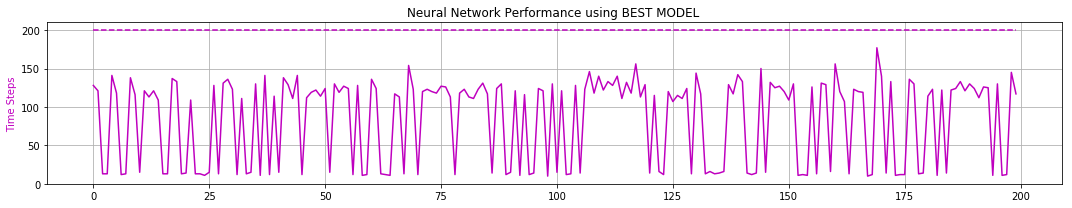

0 -max- [ 0.181  0.814  0.051  0.905  0.425]
0 -min- [-2.395 -2.436 -0.209 -1.407  0.200]

peak memory: 6387.28 MiB, increment: 4960.75 MiB
1 -max- [ 0.190  0.975  0.052  0.935  0.449]
1 -min- [-2.360 -2.425 -0.209 -1.624  0.200]

peak memory: 6566.83 MiB, increment: 5140.28 MiB
2 -max- [ 0.178  0.816  0.049  0.948  0.475]
2 -min- [-2.384 -2.428 -0.209 -1.414  0.200]

peak memory: 6478.58 MiB, increment: 5051.95 MiB
3 -max- [ 0.188  0.824  0.049  0.925  0.500]
3 -min- [-2.359 -2.502 -0.209 -1.350  0.200]

peak memory: 6387.28 MiB, increment: 4960.83 MiB
4 -max- [ 0.196  1.018  0.050  1.003  0.525]
4 -min- [-2.259 -2.428 -0.209 -1.446  0.225]

peak memory: 6387.28 MiB, increment: 4960.75 MiB
5 -max- [ 0.197  0.957  0.050  1.102  0.550]
5 -min- [-2.365 -2.542 -0.209 -1.414  0.251]

peak memory: 6462.95 MiB, increment: 5036.35 MiB
6 -max- [ 0.190  1.015  0.051  0.993  0.575]
6 -min- [-2.399 -2.576 -0.209 -1.440  0.275]

peak memory: 6407.62 MiB, increment: 4980.94 MiB
7 -max- [ 0.197  0.9

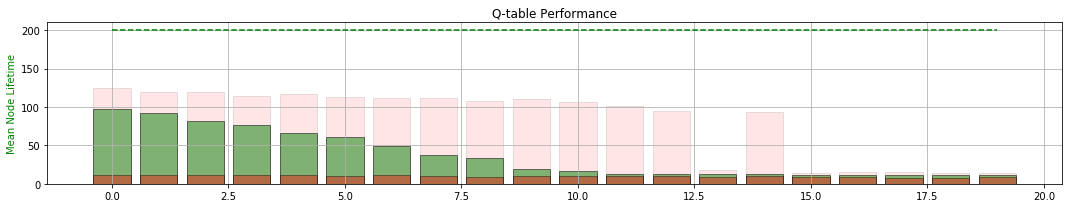

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  44000
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  12.28
Validating... MEAN TIME:  125.84
Validating... MEAN TIME:  139.79
Validating... MEAN TIME:  58.565
Validating... MEAN TIME:  151.535
TRAINING TIME:0:00:29.148993


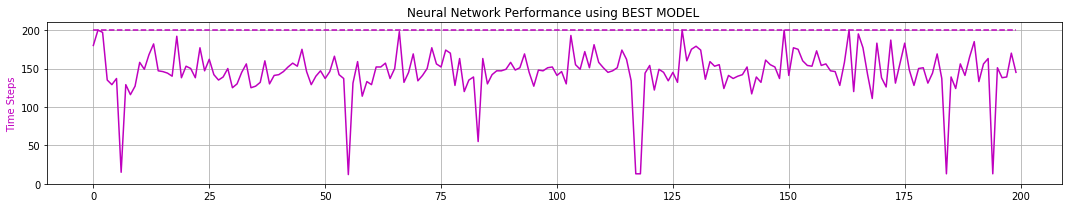

0 -max- [ 0.184  1.021  0.051  1.205  0.425]
0 -min- [-2.384 -2.595 -0.209 -1.489  0.200]

peak memory: 6418.71 MiB, increment: 4992.16 MiB
1 -max- [ 0.202  1.175  0.049  1.284  0.450]
1 -min- [-2.368 -2.688 -0.209 -1.785  0.200]

peak memory: 6431.57 MiB, increment: 5005.26 MiB
2 -max- [ 0.185  1.017  0.049  1.229  0.475]
2 -min- [-2.388 -2.715 -0.209 -1.550  0.200]

peak memory: 6387.29 MiB, increment: 4960.90 MiB
3 -max- [ 0.200  1.196  0.049  1.124  0.500]
3 -min- [-2.377 -2.786 -0.209 -1.662  0.200]

peak memory: 6478.34 MiB, increment: 5052.13 MiB
4 -max- [ 0.212  1.214  0.050  1.146  0.524]
4 -min- [-2.369 -2.782 -0.209 -1.671  0.226]

peak memory: 6442.53 MiB, increment: 5016.25 MiB
5 -max- [ 0.211  1.211  0.050  1.214  0.549]
5 -min- [-2.392 -2.876 -0.209 -1.690  0.250]

peak memory: 6387.29 MiB, increment: 4961.19 MiB
6 -max- [ 0.207  1.207  0.054  1.262  0.573]
6 -min- [-2.398 -2.782 -0.209 -1.667  0.275]

peak memory: 6387.29 MiB, increment: 4961.12 MiB
7 -max- [ 0.201  1.2

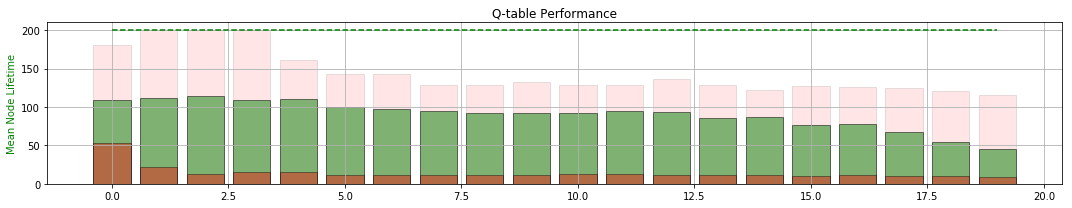

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  47994
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  42.89
Validating... MEAN TIME:  182.18
Validating... MEAN TIME:  135.0
Validating... MEAN TIME:  172.105
Validating... MEAN TIME:  190.305
TRAINING TIME:0:00:38.497287


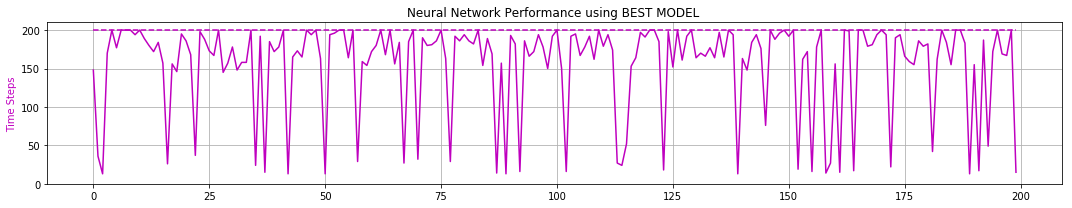

0 -max- [ 0.791  1.146  0.209  1.468  0.425]
0 -min- [-2.046 -2.585 -0.209 -1.355  0.200]

peak memory: 6563.06 MiB, increment: 5094.71 MiB
1 -max- [ 0.759  1.244  0.209  1.311  0.450]
1 -min- [-2.294 -2.571 -0.209 -1.350  0.200]

peak memory: 6508.79 MiB, increment: 5040.43 MiB
2 -max- [ 0.775  1.269  0.209  1.324  0.474]
2 -min- [-2.188 -2.579 -0.209 -1.362  0.200]

peak memory: 6473.90 MiB, increment: 5005.47 MiB
3 -max- [ 0.714  1.121  0.209  1.436  0.500]
3 -min- [-2.317 -2.711 -0.209 -1.386  0.201]

peak memory: 6473.89 MiB, increment: 5005.39 MiB
4 -max- [ 0.152  0.833  0.064  1.726  0.525]
4 -min- [-2.125 -2.543 -0.209 -1.451  0.225]

peak memory: 6462.45 MiB, increment: 4993.88 MiB
5 -max- [ 0.156  0.833  0.050  1.482  0.549]
5 -min- [-2.358 -2.703 -0.209 -1.380  0.251]

peak memory: 6637.39 MiB, increment: 5168.75 MiB
6 -max- [ 0.167  0.826  0.059  1.561  0.574]
6 -min- [-2.247 -2.575 -0.209 -1.628  0.275]

peak memory: 6564.92 MiB, increment: 5096.21 MiB
7 -max- [ 0.179  0.8

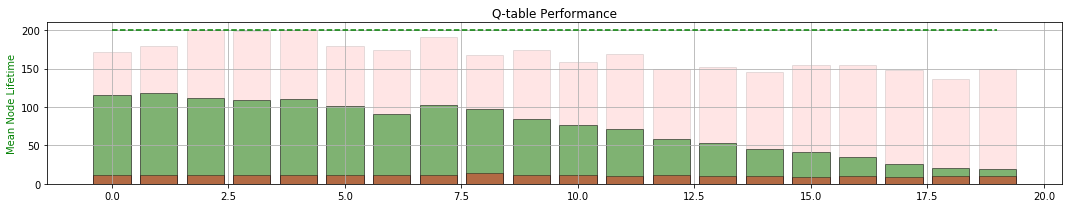

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  51992
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  61.015
Validating... MEAN TIME:  35.285
Validating... MEAN TIME:  151.62
Validating... MEAN TIME:  156.63
Validating... MEAN TIME:  199.925
TRAINING TIME:0:00:32.376481


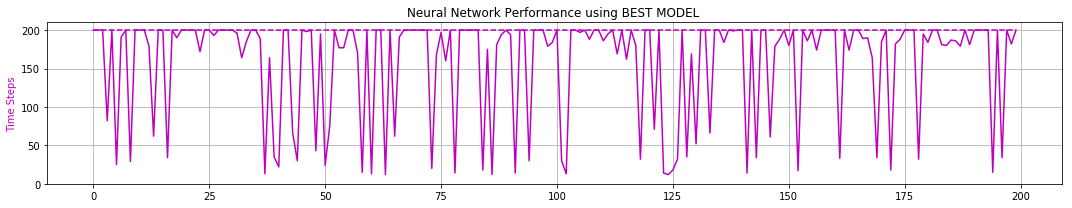

0 -max- [ 0.186  1.023  0.096  1.643  0.424]
0 -min- [-2.296 -2.427 -0.209 -1.434  0.200]

peak memory: 6438.79 MiB, increment: 5005.32 MiB
1 -max- [ 0.207  0.821  0.094  1.636  0.450]
1 -min- [-2.320 -2.510 -0.209 -1.594  0.200]

peak memory: 6426.86 MiB, increment: 4993.37 MiB
2 -max- [ 0.185  0.799  0.101  1.641  0.475]
2 -min- [-2.366 -2.702 -0.209 -1.486  0.200]

peak memory: 6586.80 MiB, increment: 5153.24 MiB
3 -max- [ 0.222  0.854  0.133  1.795  0.500]
3 -min- [-2.373 -2.609 -0.209 -1.927  0.200]

peak memory: 6439.09 MiB, increment: 5005.46 MiB
4 -max- [ 0.200  0.841  0.099  1.836  0.525]
4 -min- [-2.303 -2.517 -0.209 -1.648  0.226]

peak memory: 6439.13 MiB, increment: 5005.43 MiB
5 -max- [ 0.204  1.016  0.097  1.849  0.549]
5 -min- [-2.332 -2.542 -0.209 -1.568  0.250]

peak memory: 6581.39 MiB, increment: 5147.62 MiB
6 -max- [ 0.222  0.991  0.106  1.907  0.575]
6 -min- [-2.322 -2.579 -0.209 -1.719  0.275]

peak memory: 6589.81 MiB, increment: 5155.96 MiB
7 -max- [ 0.210  0.9

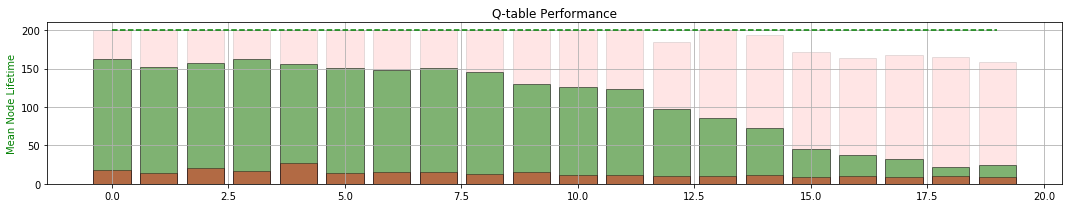

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  55845
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.9
Validating... MEAN TIME:  126.565
Validating... MEAN TIME:  171.28
Validating... MEAN TIME:  172.94
Validating... MEAN TIME:  12.22
TRAINING TIME:0:00:36.473936


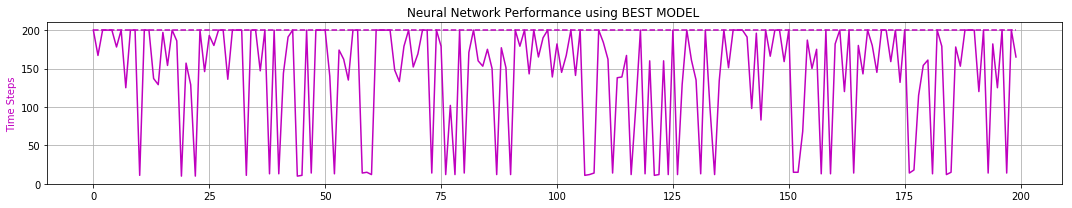

0 -max- [ 1.558  1.265  0.169  2.136  0.425]
0 -min- [-2.400 -2.618 -0.209 -1.600  0.200]

peak memory: 6450.60 MiB, increment: 4960.82 MiB
1 -max- [ 0.197  0.826  0.178  2.048  0.450]
1 -min- [-2.400 -2.636 -0.209 -1.535  0.200]

peak memory: 6530.33 MiB, increment: 5040.52 MiB
2 -max- [ 0.191  0.829  0.204  1.966  0.474]
2 -min- [-2.400 -2.591 -0.209 -1.619  0.200]

peak memory: 6495.25 MiB, increment: 5005.37 MiB
3 -max- [ 0.198  0.939  0.193  2.006  0.499]
3 -min- [-2.400 -2.633 -0.208 -1.562  0.200]

peak memory: 6532.40 MiB, increment: 5042.45 MiB
4 -max- [ 0.200  0.978  0.208  1.968  0.525]
4 -min- [-2.400 -2.612 -0.207 -1.710  0.225]

peak memory: 6449.10 MiB, increment: 4959.33 MiB
5 -max- [ 0.204  0.945  0.200  2.143  0.550]
5 -min- [-2.399 -2.614 -0.209 -1.634  0.251]

peak memory: 6449.26 MiB, increment: 4959.68 MiB
6 -max- [ 0.195  1.017  0.199  2.237  0.574]
6 -min- [-2.400 -2.619 -0.209 -1.666  0.275]

peak memory: 6595.65 MiB, increment: 5105.74 MiB
7 -max- [ 0.222  0.9

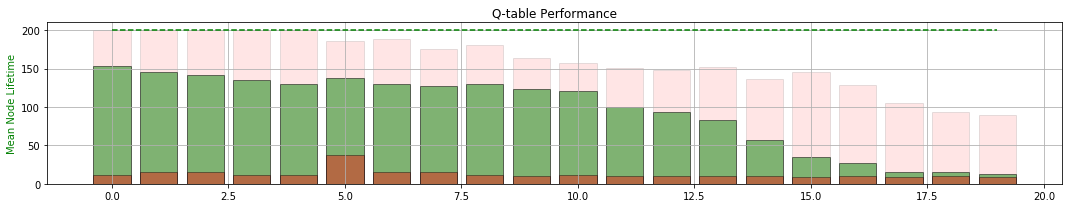

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  59811
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  198.565
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  137.72
Validating... MEAN TIME:  196.8
TRAINING TIME:0:00:45.382251


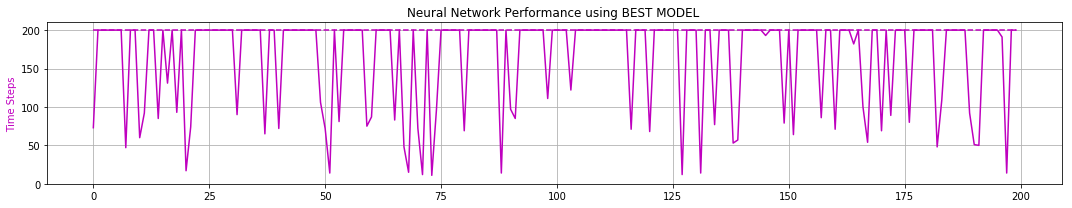

0 -max- [ 0.207  0.812  0.091  1.540  0.425]
0 -min- [-2.400 -2.577 -0.209 -1.303  0.200]

peak memory: 6445.52 MiB, increment: 5005.12 MiB
1 -max- [ 0.207  0.829  0.090  1.487  0.449]
1 -min- [-2.400 -2.585 -0.209 -1.480  0.200]

peak memory: 6445.96 MiB, increment: 5006.06 MiB
2 -max- [ 0.190  0.818  0.097  1.499  0.474]
2 -min- [-2.400 -2.588 -0.207 -1.402  0.200]

peak memory: 6445.60 MiB, increment: 5005.88 MiB
3 -max- [ 0.207  0.830  0.110  1.600  0.499]
3 -min- [-2.400 -2.783 -0.209 -1.431  0.200]

peak memory: 6434.96 MiB, increment: 4994.91 MiB
4 -max- [ 0.200  0.834  0.099  1.547  0.525]
4 -min- [-2.400 -2.889 -0.209 -1.493  0.225]

peak memory: 6544.09 MiB, increment: 5103.97 MiB
5 -max- [ 0.204  0.832  0.097  1.558  0.550]
5 -min- [-2.400 -2.933 -0.209 -1.664  0.252]

peak memory: 6445.56 MiB, increment: 5005.37 MiB
6 -max- [ 0.186  0.816  0.083  1.470  0.574]
6 -min- [-2.400 -2.804 -0.209 -1.567  0.276]

peak memory: 6445.73 MiB, increment: 5005.47 MiB
7 -max- [ 0.171  0.8

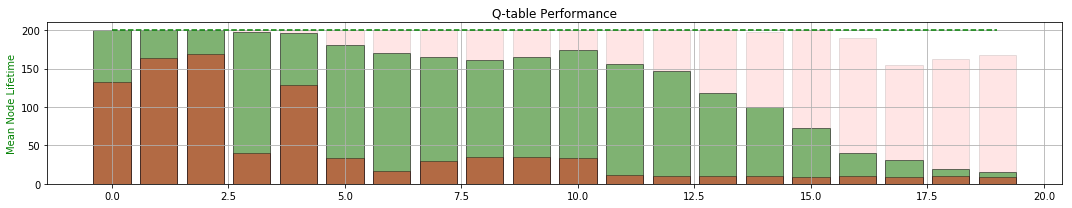

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  62231
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  12.415
Validating... MEAN TIME:  12.53
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:34.563011


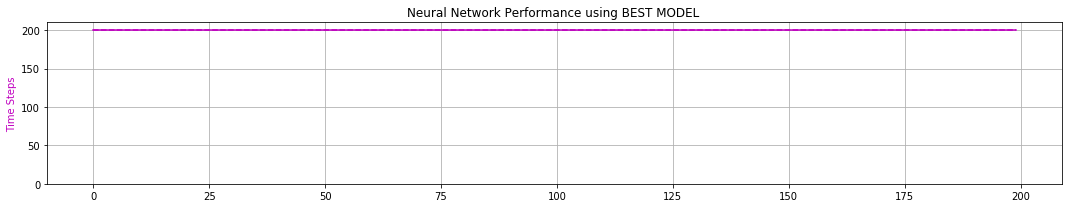

0 -max- [ 1.970  1.988  0.209  1.910  0.424]
0 -min- [-2.056 -2.228 -0.173 -1.221  0.200]

peak memory: 6547.56 MiB, increment: 5042.15 MiB
1 -max- [ 2.381  2.149  0.188  1.635  0.450]
1 -min- [-2.391 -1.854 -0.191 -1.354  0.200]

peak memory: 6665.62 MiB, increment: 5160.19 MiB
2 -max- [ 2.398  2.004  0.200  2.656  0.475]
2 -min- [-2.393 -2.887 -0.164 -1.366  0.200]

peak memory: 6559.97 MiB, increment: 5054.48 MiB
3 -max- [ 1.747  1.194  0.205  2.600  0.499]
3 -min- [-2.393 -2.891 -0.205 -1.593  0.200]

peak memory: 6627.37 MiB, increment: 5122.06 MiB
4 -max- [ 2.363  2.200  0.208  2.836  0.525]
4 -min- [-2.397 -3.022 -0.204 -1.640  0.225]

peak memory: 6603.20 MiB, increment: 5098.08 MiB
5 -max- [ 1.776  1.195  0.197  2.858  0.549]
5 -min- [-2.399 -3.073 -0.209 -1.566  0.251]

peak memory: 6603.37 MiB, increment: 5098.18 MiB
6 -max- [ 1.682  1.194  0.205  2.594  0.575]
6 -min- [-2.398 -2.886 -0.209 -1.631  0.275]

peak memory: 6603.41 MiB, increment: 5098.15 MiB
7 -max- [ 1.456  1.1

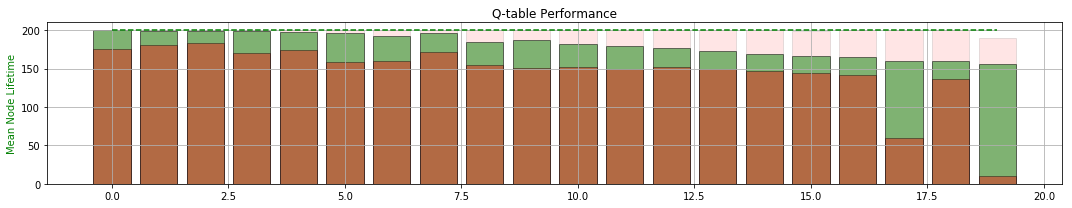

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  64832
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  184.86
Validating... MEAN TIME:  119.515
Validating... MEAN TIME:  30.67
Validating... MEAN TIME:  104.775
Validating... MEAN TIME:  44.165
TRAINING TIME:0:00:28.611872


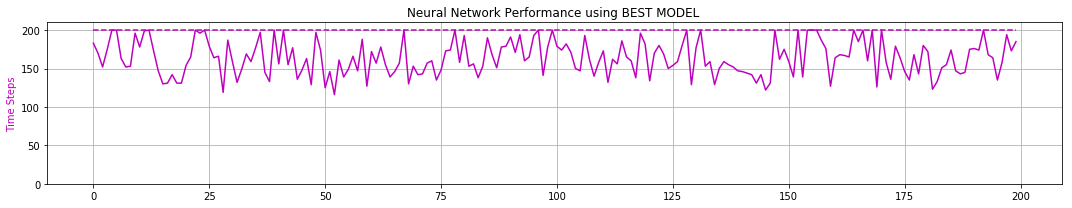

0 -max- [ 0.127  0.812  0.093  1.007  0.425]
0 -min- [-2.399 -1.814 -0.119 -1.292  0.200]

peak memory: 6605.95 MiB, increment: 5060.49 MiB
1 -max- [ 0.135  0.746  0.097  1.277  0.450]
1 -min- [-2.400 -2.095 -0.145 -1.261  0.200]

peak memory: 6540.40 MiB, increment: 4994.92 MiB
2 -max- [ 0.149  0.779  0.090  1.002  0.475]
2 -min- [-2.399 -1.659 -0.140 -1.353  0.200]

peak memory: 6550.96 MiB, increment: 5005.41 MiB
3 -max- [ 0.177  0.779  0.100  1.012  0.499]
3 -min- [-2.400 -1.818 -0.156 -1.082  0.200]

peak memory: 6551.00 MiB, increment: 5005.38 MiB
4 -max- [ 0.323  0.820  0.084  1.026  0.525]
4 -min- [-2.400 -1.892 -0.168 -1.308  0.226]

peak memory: 6614.76 MiB, increment: 5069.07 MiB
5 -max- [ 0.172  0.821  0.089  1.278  0.550]
5 -min- [-2.400 -2.082 -0.168 -1.183  0.250]

peak memory: 6643.63 MiB, increment: 5098.12 MiB
6 -max- [ 0.282  0.827  0.117  1.312  0.574]
6 -min- [-2.399 -2.105 -0.180 -1.277  0.275]

peak memory: 6550.97 MiB, increment: 5005.39 MiB
7 -max- [ 0.191  0.9

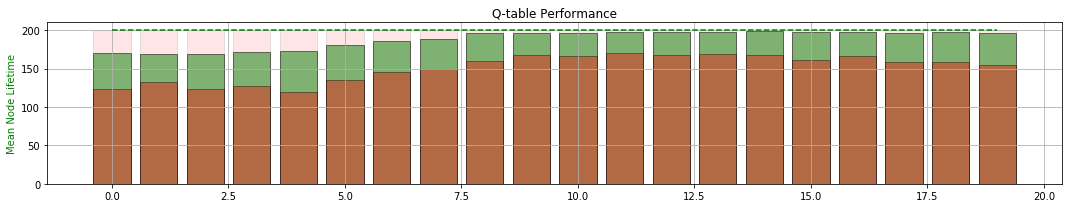

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  66468
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  12.21
Validating... MEAN TIME:  12.105
Validating... MEAN TIME:  12.02
Validating... MEAN TIME:  11.935
Validating... MEAN TIME:  12.275
TRAINING TIME:0:00:12.726236


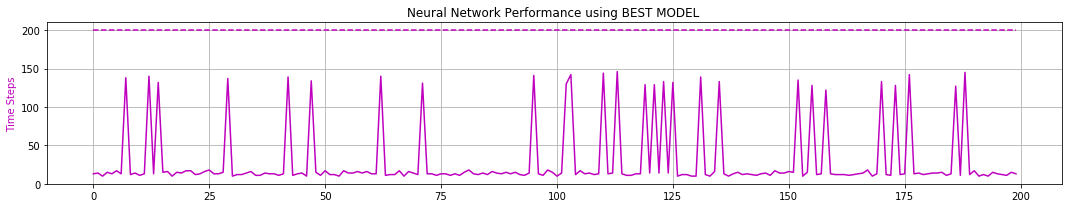

0 -max- [ 2.396  1.873  0.209  1.049  0.425]
0 -min- [-1.788 -1.683 -0.144 -0.937  0.200]

peak memory: 6582.75 MiB, increment: 4960.85 MiB
1 -max- [ 2.391  1.863  0.209  1.176  0.450]
1 -min- [-2.387 -1.887 -0.123 -0.995  0.200]

peak memory: 6582.75 MiB, increment: 4960.82 MiB
2 -max- [ 2.128  1.866  0.209  1.034  0.474]
2 -min- [-2.396 -2.067 -0.130 -1.015  0.200]

peak memory: 6582.75 MiB, increment: 4960.75 MiB
3 -max- [ 2.317  2.021  0.209  0.953  0.500]
3 -min- [-2.398 -2.077 -0.131 -0.989  0.200]

peak memory: 6715.61 MiB, increment: 5093.53 MiB
4 -max- [ 2.392  1.862  0.209  0.981  0.523]
4 -min- [-2.393 -2.191 -0.127 -1.039  0.225]

peak memory: 6673.98 MiB, increment: 5051.82 MiB
5 -max- [ 2.399  1.818  0.209  0.994  0.549]
5 -min- [-2.399 -2.255 -0.142 -0.941  0.250]

peak memory: 6732.25 MiB, increment: 5110.02 MiB
6 -max- [ 2.399  1.866  0.209  1.075  0.574]
6 -min- [-2.372 -2.239 -0.132 -1.049  0.277]

peak memory: 6631.57 MiB, increment: 5009.26 MiB
7 -max- [ 2.400  1.8

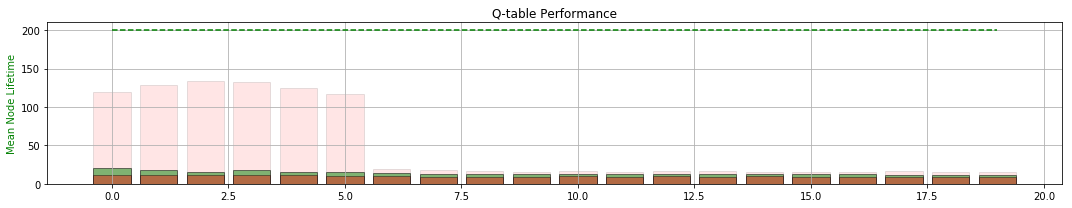

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  70468
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.855
Validating... MEAN TIME:  45.825
Validating... MEAN TIME:  110.395
Validating... MEAN TIME:  121.435
Validating... MEAN TIME:  156.6
TRAINING TIME:0:00:34.729610


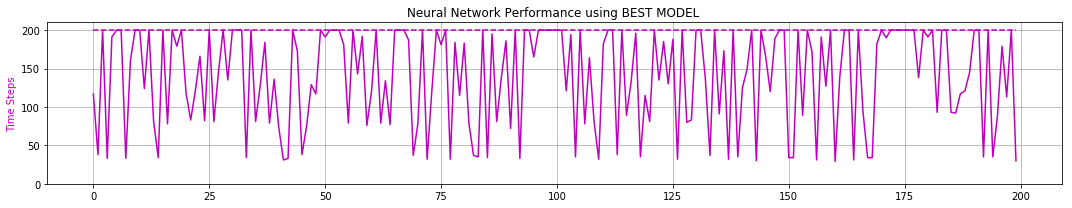

0 -max- [ 0.209  0.816  0.054  0.906  0.425]
0 -min- [-2.389 -2.414 -0.209 -1.390  0.200]

peak memory: 6346.12 MiB, increment: 5005.60 MiB
1 -max- [ 0.210  0.823  0.049  0.894  0.450]
1 -min- [-2.392 -2.438 -0.209 -1.436  0.200]

peak memory: 6346.19 MiB, increment: 5005.66 MiB
2 -max- [ 0.213  0.834  0.049  0.869  0.475]
2 -min- [-2.389 -2.231 -0.209 -1.461  0.200]

peak memory: 6493.59 MiB, increment: 5152.98 MiB
3 -max- [ 0.213  0.821  0.049  0.825  0.500]
3 -min- [-2.390 -2.434 -0.209 -1.491  0.201]

peak memory: 6363.07 MiB, increment: 5022.66 MiB
4 -max- [ 0.218  1.018  0.050  0.645  0.525]
4 -min- [-2.364 -2.231 -0.209 -1.509  0.225]

peak memory: 6465.23 MiB, increment: 5124.75 MiB
5 -max- [ 0.218  1.016  0.050  0.889  0.549]
5 -min- [-2.376 -2.434 -0.209 -1.497  0.251]

peak memory: 6493.80 MiB, increment: 5153.24 MiB
6 -max- [ 0.206  1.009  0.051  0.296  0.575]
6 -min- [-0.050 -0.220 -0.209 -1.586  0.275]

peak memory: 6450.61 MiB, increment: 5109.98 MiB
7 -max- [ 0.202  1.0

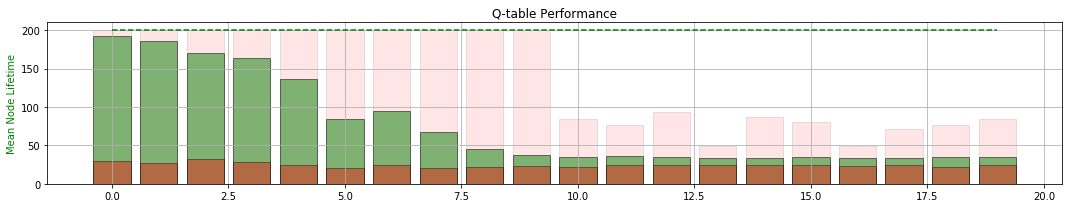

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  73519
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  35.635
Validating... MEAN TIME:  186.48
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  197.44
Validating... MEAN TIME:  199.74
TRAINING TIME:0:00:41.880301


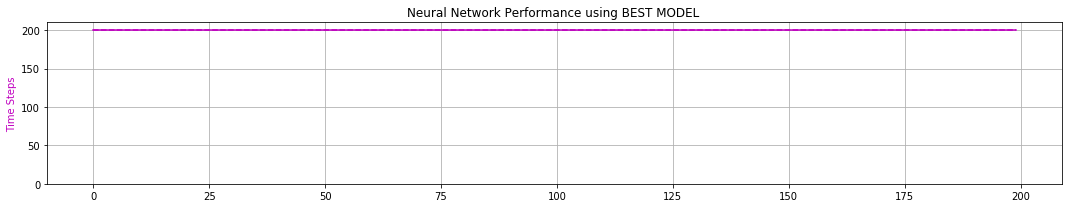

0 -max- [ 0.227  0.995  0.144  1.564  0.425]
0 -min- [-0.996 -1.563 -0.209 -1.426  0.200]

peak memory: 6405.88 MiB, increment: 5005.61 MiB
1 -max- [ 0.340  1.008  0.142  1.330  0.449]
1 -min- [-0.980 -1.379 -0.209 -1.350  0.200]

peak memory: 6458.12 MiB, increment: 5057.84 MiB
2 -max- [ 0.504  1.182  0.158  1.542  0.474]
2 -min- [-0.986 -1.386 -0.209 -1.622  0.200]

peak memory: 6427.65 MiB, increment: 5027.30 MiB
3 -max- [ 0.320  1.149  0.167  1.542  0.499]
3 -min- [-0.797 -1.570 -0.209 -1.539  0.201]

peak memory: 6526.10 MiB, increment: 5125.93 MiB
4 -max- [ 0.321  1.188  0.182  1.589  0.524]
4 -min- [-0.827 -1.394 -0.209 -1.597  0.225]

peak memory: 6482.12 MiB, increment: 5081.89 MiB
5 -max- [ 0.372  1.164  0.156  1.532  0.549]
5 -min- [-1.248 -1.480 -0.209 -1.596  0.250]

peak memory: 6430.37 MiB, increment: 5030.32 MiB
6 -max- [ 0.307  1.193  0.174  1.584  0.575]
6 -min- [-1.337 -1.547 -0.209 -1.581  0.276]

peak memory: 6498.52 MiB, increment: 5098.39 MiB
7 -max- [ 0.315  1.1

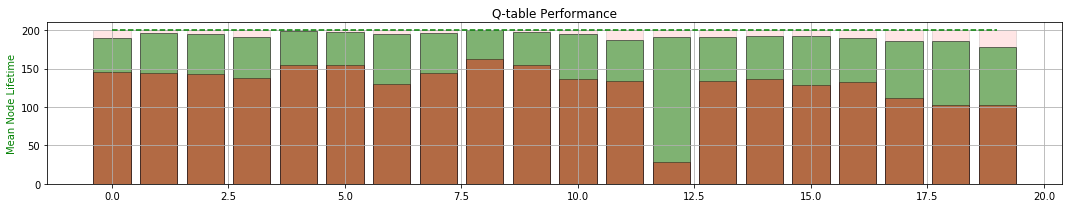

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  74798
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.97
Validating... MEAN TIME:  13.14
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  20.84
Validating... MEAN TIME:  164.25
TRAINING TIME:0:00:32.221975


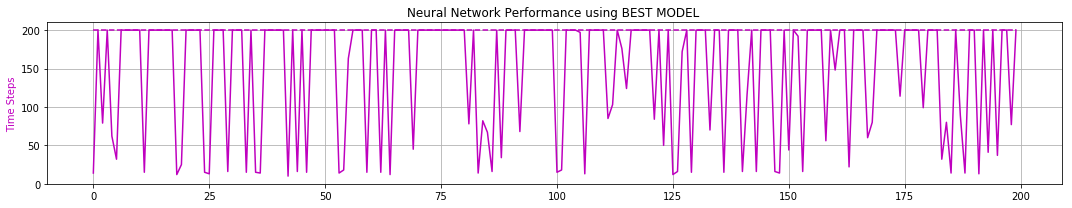

0 -max- [ 0.131  0.944  0.199  1.192  0.425]
0 -min- [-1.447 -1.615 -0.209 -1.293  0.200]

peak memory: 6650.91 MiB, increment: 5022.61 MiB
1 -max- [ 0.142  0.938  0.087  0.938  0.450]
1 -min- [-1.442 -1.608 -0.209 -1.310  0.200]

peak memory: 6688.35 MiB, increment: 5060.03 MiB
2 -max- [ 0.177  0.783  0.117  1.018  0.474]
2 -min- [-1.487 -1.669 -0.209 -1.246  0.200]

peak memory: 6633.54 MiB, increment: 5005.66 MiB
3 -max- [ 0.165  0.765  0.187  1.205  0.500]
3 -min- [-1.485 -1.667 -0.209 -1.260  0.200]

peak memory: 6791.77 MiB, increment: 5163.82 MiB
4 -max- [ 0.203  0.932  0.079  0.957  0.524]
4 -min- [-1.460 -1.629 -0.209 -1.311  0.225]

peak memory: 6716.62 MiB, increment: 5088.34 MiB
5 -max- [ 0.208  0.821  0.084  0.985  0.550]
5 -min- [-1.386 -1.603 -0.209 -1.247  0.251]

peak memory: 6633.80 MiB, increment: 5005.46 MiB
6 -max- [ 0.313  0.824  0.077  0.836  0.575]
6 -min- [-1.500 -1.773 -0.209 -1.276  0.275]

peak memory: 6667.55 MiB, increment: 5039.13 MiB
7 -max- [ 0.280  0.8

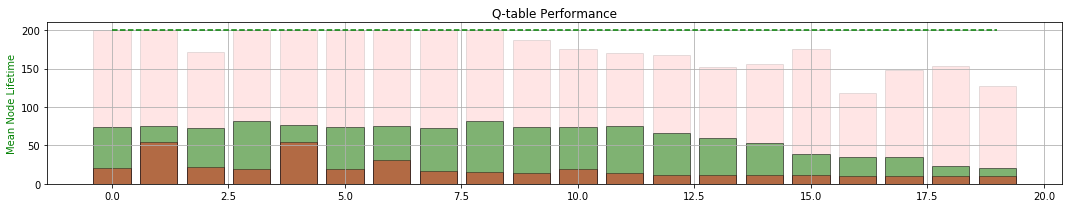

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  78779
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  93.735
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:44.911515


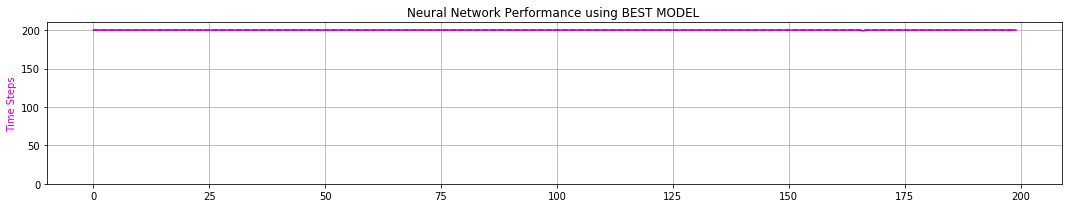

0 -max- [ 0.176  0.909  0.209  2.028  0.424]
0 -min- [-0.767 -1.854 -0.209 -1.225  0.200]

peak memory: 6519.24 MiB, increment: 5121.86 MiB
1 -max- [ 0.197  0.925  0.209  1.848  0.449]
1 -min- [-0.775 -1.842 -0.204 -1.211  0.200]

peak memory: 6577.56 MiB, increment: 5179.90 MiB
2 -max- [ 0.223  0.914  0.209  1.899  0.475]
2 -min- [-0.827 -1.889 -0.208 -1.174  0.200]

peak memory: 6494.31 MiB, increment: 5096.58 MiB
3 -max- [ 0.213  0.941  0.209  1.764  0.500]
3 -min- [-0.798 -1.944 -0.208 -1.105  0.200]

peak memory: 6391.94 MiB, increment: 4994.14 MiB
4 -max- [ 0.185  0.924  0.209  1.788  0.524]
4 -min- [-0.825 -1.863 -0.209 -1.327  0.225]

peak memory: 6404.45 MiB, increment: 5006.84 MiB
5 -max- [ 0.195  0.921  0.209  1.801  0.549]
5 -min- [-0.779 -1.872 -0.202 -1.319  0.250]

peak memory: 6586.93 MiB, increment: 5189.25 MiB
6 -max- [ 0.180  0.923  0.209  1.557  0.575]
6 -min- [-0.788 -1.725 -0.208 -1.105  0.275]

peak memory: 6403.16 MiB, increment: 5005.41 MiB
7 -max- [ 0.205  0.9

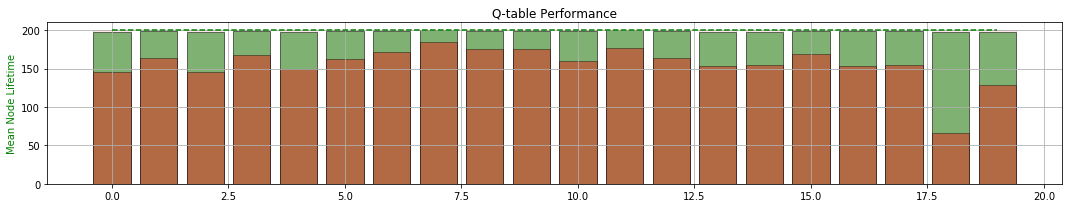

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  79191
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  14.025
Validating... MEAN TIME:  198.725
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  182.545
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:40.540902


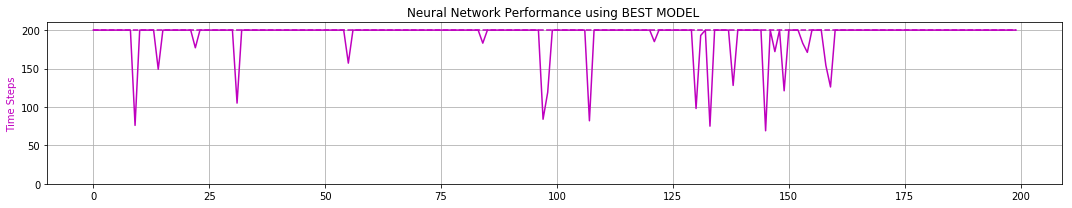

0 -max- [ 2.138  1.857  0.208  1.476  0.425]
0 -min- [-1.660 -1.352 -0.130 -1.130  0.200]

peak memory: 6643.26 MiB, increment: 5094.25 MiB
1 -max- [ 2.025  1.669  0.209  1.365  0.450]
1 -min- [-1.630 -1.617 -0.206 -1.053  0.200]

peak memory: 6640.63 MiB, increment: 5091.61 MiB
2 -max- [ 1.938  1.353  0.209  1.682  0.475]
2 -min- [-1.884 -1.734 -0.207 -1.074  0.200]

peak memory: 6554.57 MiB, increment: 5005.47 MiB
3 -max- [ 2.317  1.678  0.208  1.492  0.499]
3 -min- [-1.661 -1.603 -0.209 -1.348  0.201]

peak memory: 6647.24 MiB, increment: 5098.07 MiB
4 -max- [ 1.361  1.140  0.209  1.517  0.524]
4 -min- [-1.797 -1.676 -0.209 -1.090  0.225]

peak memory: 6673.84 MiB, increment: 5124.61 MiB
5 -max- [ 0.614  0.981  0.208  1.440  0.549]
5 -min- [-1.681 -1.591 -0.209 -1.361  0.250]

peak memory: 6722.21 MiB, increment: 5172.90 MiB
6 -max- [ 0.405  0.974  0.204  1.484  0.574]
6 -min- [-1.707 -1.617 -0.209 -1.307  0.275]

peak memory: 6554.77 MiB, increment: 5005.65 MiB
7 -max- [ 0.165  0.8

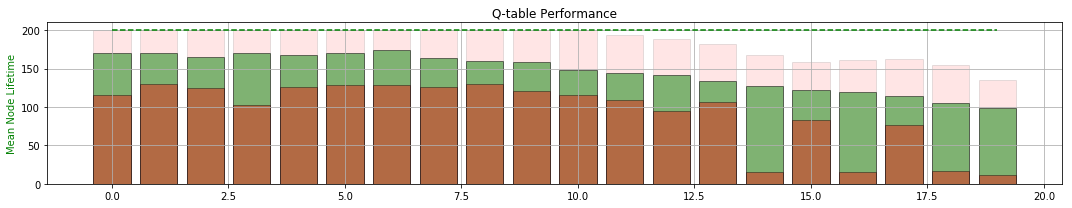

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  83064
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  17.95
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  133.225
TRAINING TIME:0:00:39.265356


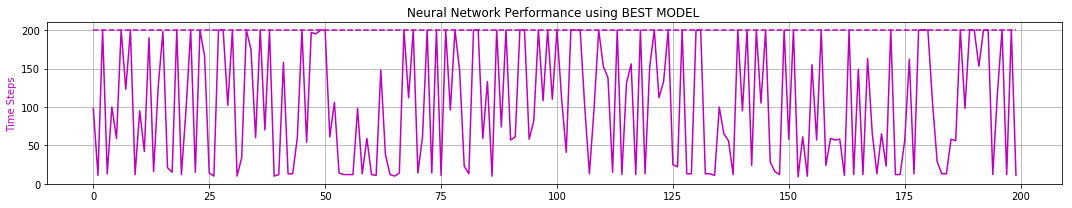

0 -max- [ 0.149  1.315  0.209  1.357  0.424]
0 -min- [-1.628 -1.491 -0.134 -1.051  0.200]

peak memory: 6690.38 MiB, increment: 5144.47 MiB
1 -max- [ 0.162  0.824  0.209  1.449  0.450]
1 -min- [-1.598 -1.344 -0.144 -1.171  0.200]

peak memory: 6639.29 MiB, increment: 5093.36 MiB
2 -max- [ 0.989  2.031  0.209  1.720  0.475]
2 -min- [-1.876 -2.032 -0.164 -1.219  0.200]

peak memory: 6551.36 MiB, increment: 5005.36 MiB
3 -max- [ 0.196  1.653  0.209  1.971  0.500]
3 -min- [-2.391 -2.821 -0.205 -1.170  0.200]

peak memory: 6551.46 MiB, increment: 5005.39 MiB
4 -max- [ 0.181  0.809  0.209  2.225  0.525]
4 -min- [-2.397 -3.014 -0.209 -1.149  0.226]

peak memory: 6659.20 MiB, increment: 5113.05 MiB
5 -max- [ 0.160  0.961  0.209  2.160  0.550]
5 -min- [-2.399 -2.804 -0.209 -1.131  0.250]

peak memory: 6736.77 MiB, increment: 5190.55 MiB
6 -max- [ 0.154  0.933  0.209  2.310  0.574]
6 -min- [-2.394 -2.874 -0.209 -1.343  0.275]

peak memory: 6551.34 MiB, increment: 5005.30 MiB
7 -max- [ 0.191  0.8

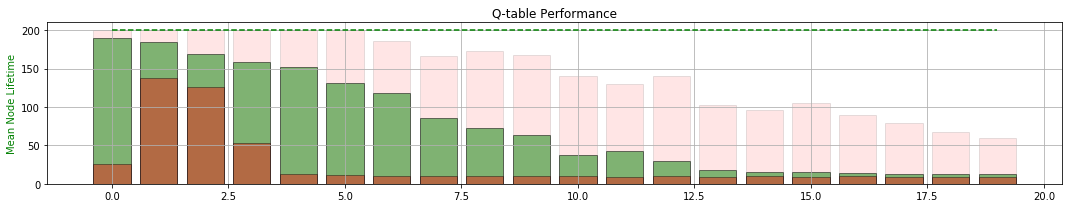

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  86841
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  176.68
Validating... MEAN TIME:  12.35
Validating... MEAN TIME:  11.235
Validating... MEAN TIME:  13.45
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:26.353323


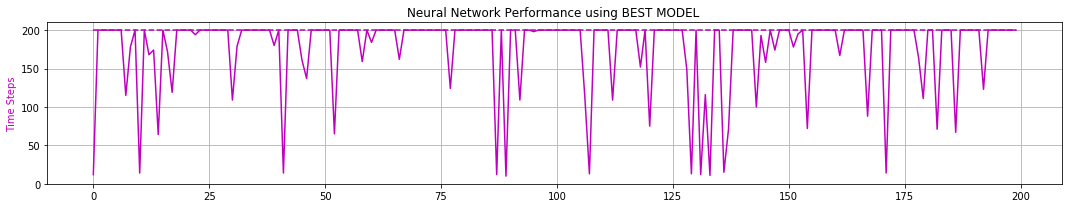

0 -max- [ 0.158  0.823  0.098  1.288  0.425]
0 -min- [-2.213 -1.503 -0.209 -1.390  0.200]

peak memory: 6520.87 MiB, increment: 5098.09 MiB
1 -max- [ 0.194  0.834  0.207  1.282  0.449]
1 -min- [-2.270 -1.615 -0.209 -1.607  0.200]

peak memory: 6462.11 MiB, increment: 5039.31 MiB
2 -max- [ 0.185  0.936  0.204  1.281  0.475]
2 -min- [-2.268 -1.603 -0.209 -1.352  0.200]

peak memory: 6612.77 MiB, increment: 5189.91 MiB
3 -max- [ 0.196  0.822  0.085  1.267  0.499]
3 -min- [-1.870 -1.535 -0.209 -1.699  0.200]

peak memory: 6446.66 MiB, increment: 5023.98 MiB
4 -max- [ 0.174  0.809  0.082  1.301  0.525]
4 -min- [-2.061 -1.701 -0.209 -1.544  0.225]

peak memory: 6559.74 MiB, increment: 5137.00 MiB
5 -max- [ 0.156  1.016  0.095  1.273  0.550]
5 -min- [-1.804 -1.672 -0.209 -1.584  0.251]

peak memory: 6593.94 MiB, increment: 5171.64 MiB
6 -max- [ 0.194  1.024  0.087  1.277  0.575]
6 -min- [-1.512 -1.643 -0.209 -1.726  0.276]

peak memory: 6428.35 MiB, increment: 5005.98 MiB
7 -max- [ 0.190  1.0

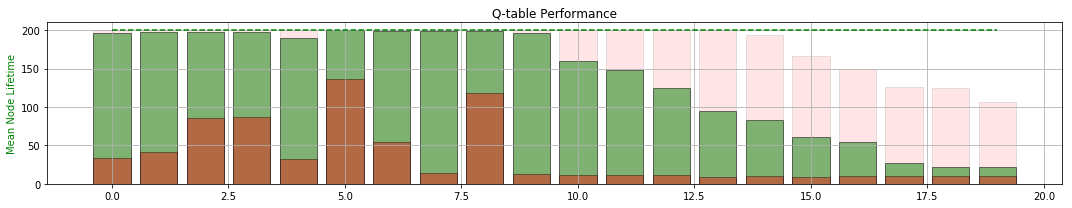

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  88869
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.835
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  158.83
Validating... MEAN TIME:  181.185
TRAINING TIME:0:00:45.300099


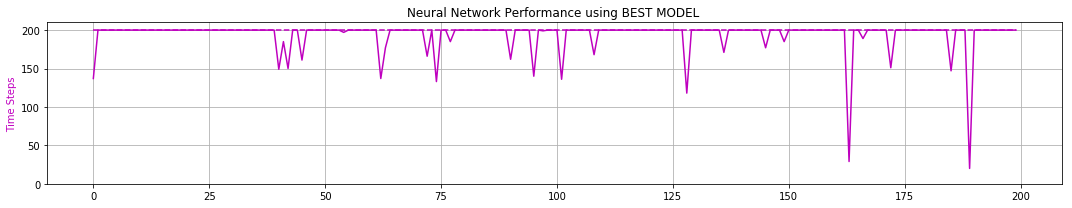

0 -max- [ 2.399  2.161  0.178  1.430  0.425]
0 -min- [-0.695 -1.114 -0.208 -1.401  0.200]

peak memory: 6537.26 MiB, increment: 4994.34 MiB
1 -max- [ 2.395  1.620  0.151  1.014  0.450]
1 -min- [-0.925 -1.139 -0.205 -1.308  0.200]

peak memory: 6629.08 MiB, increment: 5086.41 MiB
2 -max- [ 1.349  2.139  0.207  1.209  0.475]
2 -min- [-0.957 -1.164 -0.209 -1.399  0.200]

peak memory: 6625.66 MiB, increment: 5083.43 MiB
3 -max- [ 1.229  1.620  0.186  1.183  0.500]
3 -min- [-1.356 -1.192 -0.209 -1.340  0.200]

peak memory: 6547.85 MiB, increment: 5005.55 MiB
4 -max- [ 1.815  1.468  0.177  1.158  0.525]
4 -min- [-1.440 -1.175 -0.209 -1.488  0.226]

peak memory: 6695.87 MiB, increment: 5153.24 MiB
5 -max- [ 0.671  1.098  0.169  1.129  0.550]
5 -min- [-1.611 -1.311 -0.209 -1.341  0.250]

peak memory: 6640.79 MiB, increment: 5098.10 MiB
6 -max- [ 0.231  1.341  0.208  1.342  0.575]
6 -min- [-1.444 -1.544 -0.209 -1.681  0.275]

peak memory: 6548.12 MiB, increment: 5005.36 MiB
7 -max- [ 0.191  1.5

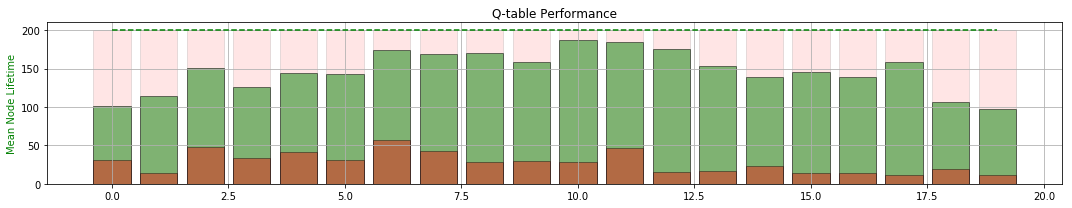

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  90799
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.985
Validating... MEAN TIME:  179.955
Validating... MEAN TIME:  149.535
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  45.63
TRAINING TIME:0:00:40.160225


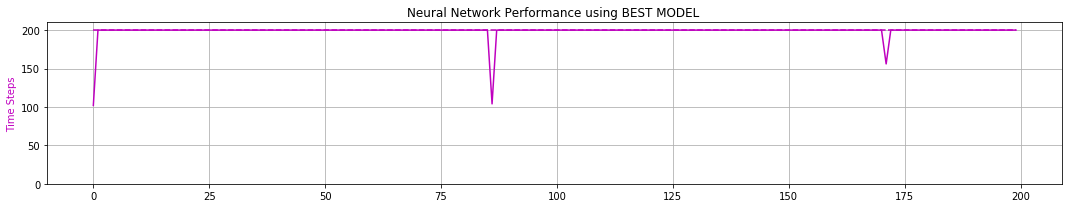

0 -max- [ 1.526  1.697  0.208  1.342  0.424]
0 -min- [-0.482 -1.180 -0.209 -1.431  0.200]

peak memory: 6524.40 MiB, increment: 5005.68 MiB
1 -max- [ 1.582  1.816  0.209  1.800  0.449]
1 -min- [-0.158 -1.130 -0.209 -1.434  0.200]

peak memory: 6604.34 MiB, increment: 5085.35 MiB
2 -max- [ 1.551  1.649  0.206  1.521  0.475]
2 -min- [-0.557 -1.179 -0.209 -1.428  0.200]

peak memory: 6617.11 MiB, increment: 5098.31 MiB
3 -max- [ 1.454  1.700  0.208  1.329  0.499]
3 -min- [-0.296 -1.157 -0.209 -1.566  0.200]

peak memory: 6691.79 MiB, increment: 5172.91 MiB
4 -max- [ 1.224  1.527  0.193  1.313  0.525]
4 -min- [-0.259 -1.151 -0.209 -1.455  0.226]

peak memory: 6617.00 MiB, increment: 5098.31 MiB
5 -max- [ 1.091  1.551  0.206  1.304  0.550]
5 -min- [-0.487 -1.284 -0.209 -1.462  0.250]

peak memory: 6561.36 MiB, increment: 5042.60 MiB
6 -max- [ 1.245  1.454  0.196  1.501  0.574]
6 -min- [-0.557 -1.169 -0.209 -1.583  0.275]

peak memory: 6681.32 MiB, increment: 5162.50 MiB
7 -max- [ 0.992  1.5

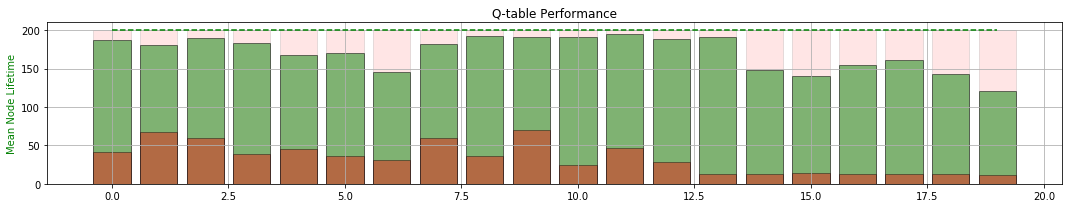

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  92236
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  94.9
Validating... MEAN TIME:  59.16
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:39.491125


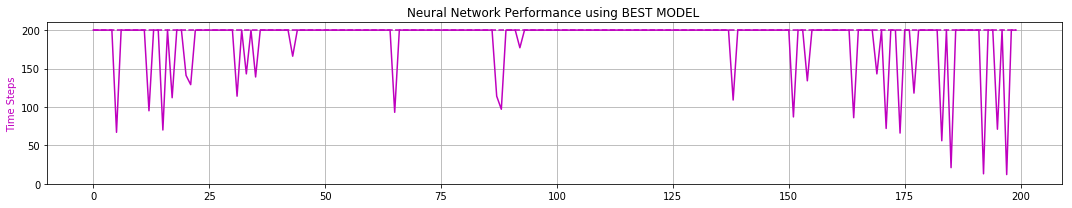

0 -max- [ 1.648  1.736  0.196  1.478  0.425]
0 -min- [-0.472 -0.988 -0.209 -1.574  0.200]

peak memory: 6689.42 MiB, increment: 5125.64 MiB
1 -max- [ 1.982  1.839  0.208  1.337  0.450]
1 -min- [-0.997 -1.003 -0.209 -1.540  0.200]

peak memory: 6740.41 MiB, increment: 5176.61 MiB
2 -max- [ 1.169  1.642  0.199  1.312  0.475]
2 -min- [-1.276 -1.139 -0.209 -1.576  0.200]

peak memory: 6569.28 MiB, increment: 5005.41 MiB
3 -max- [ 1.496  1.664  0.194  1.319  0.500]
3 -min- [-0.860 -1.138 -0.209 -1.601  0.201]

peak memory: 6569.41 MiB, increment: 5005.47 MiB
4 -max- [ 1.083  1.573  0.171  1.462  0.524]
4 -min- [-1.070 -1.155 -0.209 -1.712  0.226]

peak memory: 6614.16 MiB, increment: 5050.16 MiB
5 -max- [ 1.196  1.731  0.189  1.286  0.550]
5 -min- [-0.636 -0.979 -0.209 -1.671  0.250]

peak memory: 6711.44 MiB, increment: 5147.88 MiB
6 -max- [ 0.549  1.390  0.138  1.023  0.575]
6 -min- [-1.420 -1.321 -0.209 -1.682  0.275]

peak memory: 6569.07 MiB, increment: 5005.44 MiB
7 -max- [ 0.642  1.5

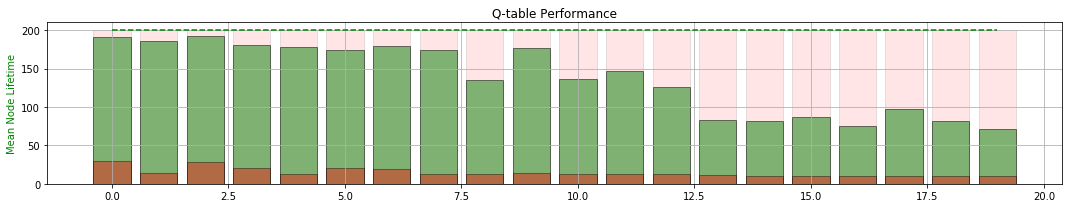

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  94353
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  127.61
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  43.01
Validating... MEAN TIME:  13.16
Validating... MEAN TIME:  198.97
TRAINING TIME:0:00:32.772967


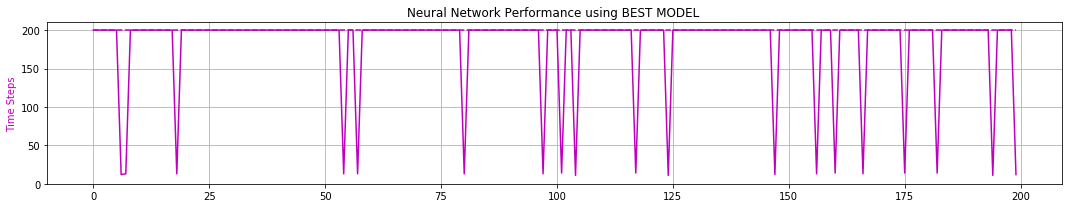

0 -max- [ 0.434  1.206  0.120  1.070  0.424]
0 -min- [-2.076 -1.324 -0.209 -1.623  0.200]

peak memory: 6481.16 MiB, increment: 5015.36 MiB
1 -max- [ 0.422  1.171  0.147  1.108  0.450]
1 -min- [-1.813 -1.180 -0.209 -1.659  0.200]

peak memory: 6508.39 MiB, increment: 5042.83 MiB
2 -max- [ 0.358  1.284  0.137  0.999  0.475]
2 -min- [-1.678 -1.320 -0.209 -1.587  0.200]

peak memory: 6471.24 MiB, increment: 5005.61 MiB
3 -max- [ 0.357  1.211  0.139  1.262  0.500]
3 -min- [-1.713 -1.470 -0.209 -1.617  0.200]

peak memory: 6480.79 MiB, increment: 5015.09 MiB
4 -max- [ 0.330  1.215  0.103  1.012  0.525]
4 -min- [-1.707 -1.498 -0.209 -1.711  0.225]

peak memory: 6494.78 MiB, increment: 5029.00 MiB
5 -max- [ 0.323  1.128  0.109  1.109  0.549]
5 -min- [-1.991 -1.655 -0.209 -1.659  0.251]

peak memory: 6471.24 MiB, increment: 5005.65 MiB
6 -max- [ 0.428  1.195  0.120  1.014  0.574]
6 -min- [-1.858 -1.639 -0.209 -1.673  0.276]

peak memory: 6458.51 MiB, increment: 4992.85 MiB
7 -max- [ 0.326  1.1

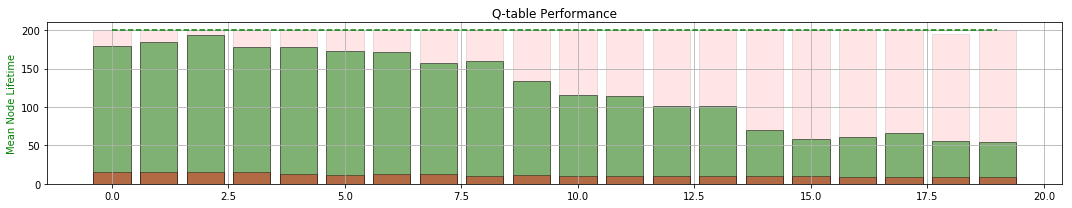

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  96719
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  119.32
Validating... MEAN TIME:  199.65
Validating... MEAN TIME:  12.405
Validating... MEAN TIME:  10.865
Validating... MEAN TIME:  197.235
TRAINING TIME:0:00:29.981656


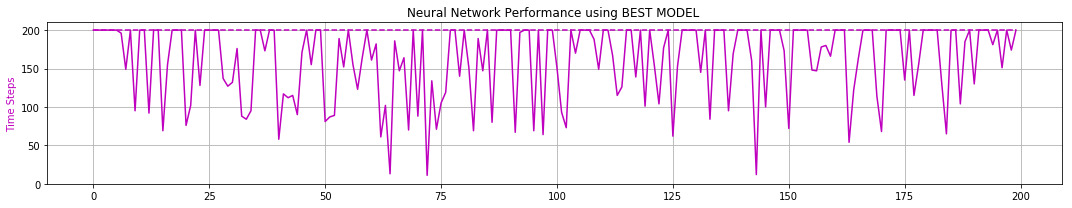

0 -max- [ 0.323  1.256  0.170  1.047  0.425]
0 -min- [-1.475 -1.273 -0.209 -1.685  0.200]

peak memory: 6599.37 MiB, increment: 5110.42 MiB
1 -max- [ 0.217  1.106  0.209  1.181  0.449]
1 -min- [-1.715 -1.366 -0.209 -1.541  0.200]

peak memory: 6494.28 MiB, increment: 5005.31 MiB
2 -max- [ 0.204  1.128  0.205  1.024  0.475]
2 -min- [-2.095 -1.362 -0.209 -1.579  0.200]

peak memory: 6498.47 MiB, increment: 5009.43 MiB
3 -max- [ 0.302  1.188  0.189  1.033  0.500]
3 -min- [-2.065 -1.592 -0.209 -1.639  0.200]

peak memory: 6628.38 MiB, increment: 5139.53 MiB
4 -max- [ 0.252  1.341  0.194  1.076  0.525]
4 -min- [-2.086 -1.845 -0.209 -1.732  0.225]

peak memory: 6507.92 MiB, increment: 5019.26 MiB
5 -max- [ 0.250  1.190  0.184  1.045  0.550]
5 -min- [-2.018 -1.786 -0.209 -1.722  0.250]

peak memory: 6511.44 MiB, increment: 5022.70 MiB
6 -max- [ 0.242  1.021  0.138  1.037  0.574]
6 -min- [-2.226 -1.853 -0.209 -1.407  0.275]

peak memory: 6494.41 MiB, increment: 5005.61 MiB
7 -max- [ 0.219  1.0

In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = 0.5 + np.random.uniform(-0.3,0.3)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = 0.5 + np.random.uniform(-0.3,0.3)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
        # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
        ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
        ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        # CREATE STATE COMBINATIONS
        ###############################################

        node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
                                            [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
                                            [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
        ###############################################

        # GET Q-VALUES 
        %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

        # SAVE QFILE
        node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
        np.save(node_QFILE, node_q_table)
        #############################################################################################################################################
    stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5312.0
Total Serial Timesteps   :  11771180.0
Speed-up                 :  2215.96


In [21]:
pool.close()
pool.join()